# 2020-05-01-coffea-demo-2

## 1. Introduction

This demo of the new Awkward Array was presented on May 1, 2020, before the version was named 1.0, but the interface is pretty nearly finalized. Nevertheless, It is only guaranteed to work in the current version, 0.2.18, so be sure to install that (from [GitHub](https://github.com/scikit-hep/awkward-1.0/releases/tag/0.2.18) or [pip](https://pypi.org/project/awkward1/0.2.18/)) before running this notebook.

```bash
pip install 'awkward1==0.2.18'
```

This demo is also based on [one I presented for the EIC collaboration](https://github.com/jpivarski/2020-04-08-eic-jlab#readme) and it uses the same file.

In [5]:
!wget https://github.com/jpivarski/2020-04-08-eic-jlab/raw/master/open_charm_18x275_10k.root

--2020-04-30 08:33:58--  https://github.com/jpivarski/2020-04-08-eic-jlab/raw/master/open_charm_18x275_10k.root
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jpivarski/2020-04-08-eic-jlab/master/open_charm_18x275_10k.root [following]
--2020-04-30 08:33:58--  https://raw.githubusercontent.com/jpivarski/2020-04-08-eic-jlab/master/open_charm_18x275_10k.root
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.28.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.28.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51484369 (49M) [application/octet-stream]
Saving to: ‘open_charm_18x275_10k.root’

open_charm_18x275_1 100%[===================>]  49.10M   648KB/s    in 79s     

2020-04-30 08:35:18 (634 KB/s) - ‘open_charm_18x275_10k.root’ saved [514

In [1]:
# The base of the GitHub repo is one level up from this notebook.
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

## 2. Awkward 1 is ready for users, Uproot 4 is not

The only hold-up is that Uproot does not yet produce Awkward 1 arrays, so there's an extra step to turn Awkward 0 arrays into Awkward 1. This conversion is zero-copy (changing names and metadata, but not the array buffers.)

In [2]:
import awkward1 as ak
import uproot

In [3]:
dataset = uproot.open("open_charm_18x275_10k.root")["events/tree"]

In [4]:
# old style
dataset.array("p")

<JaggedArray [[3.2559399993304847 2.196008973692167 2.2949584126781573 ... 0.2419069110316996 0.07194669925781395 0.17262100274545228] [15.846170317435083 0.25560661725265565 1.6318635601175377 ... 0.5642153466643426 0.6807703422724426 0.22676951924278516] [17.897245463728172 42.704132482765466 7.375745975693497 ... 1.4577356674201494 0.12523958867283935 1.5252133879925078] ... [14.275052868713722 0.9663850084397464 0.5160838480632304 ... 0.28541577237872157 0.2146085477379938 1.2414678978190163] [15.889411465092804 52.81059318615546 3.0411592432914123 ... 1.148414045783123 0.06047451686329056 6.562005262653488] [18.518626487094572 1.6368244960746605 4.179017474861343 ... 6.980027298771285 0.09555171117336275 3.043827450063815]] at 0x7f6d8a2fc450>

In [5]:
# new style
ak.from_awkward0(dataset.array("p"))

<Array [[3.26, 2.2, 2.29, ... 0.0956, 3.04]] type='10000 * var * float64'>

Let's read them all into new-style arrays.

In [6]:
arrays = {name: ak.from_awkward0(array) for name, array in dataset.arrays(namedecode="utf-8").items()}
arrays

{'evt_id': <Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='10000 * uint64'>,
 'evt_true_q2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_x': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_y': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_w2': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_true_nu': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'evt_has_dis_info': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * int8'>,
 'evt_prt_count': <Array [51, 26, 27, 28, 30, ... 37, 42, 25, 11] type='10000 * uint64'>,
 'evt_weight': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='10000 * float64'>,
 'id': <Array [[12, 79, 80, 81, ... 54, 60, 61, 62]] type='10000 * var * uint64'>,
 'pdg': <Array [[11, 211, -211, -321, ... 130, 22, 22]] type='10000 * var * int64'>,
 'trk_id': <Array [[0, 0, 0, 0, 0, 0,

In general, it's more useful for data to be combined into a single structure (like NanoEvents), rather than a dict or variables pointing to separate arrays.

There are tools for building structures (and they're zero-copy, as much as possible).

In [7]:
example = ak.zip({"px": arrays["px"], "py": arrays["py"], "pz": arrays["pz"]})
example

<Array [[{px: -0.516, ... pz: -3.02}]] type='10000 * var * {"px": float64, "py":...'>

In [8]:
example[0, 0]

<Record {px: -0.516, py: 0.0892, pz: 3.21} type='{"px": float64, "py": float64, ...'>

Building such a structure requires some knowledge of what the ROOT branches mean, but this can be done once for NanoAOD (NanoEvents!).

In [9]:
events = ak.zip({"id": arrays["evt_id"],
                 "true": ak.zip({"q2": arrays["evt_true_q2"],
                                 "x": arrays["evt_true_x"],
                                 "y": arrays["evt_true_y"],
                                 "w2": arrays["evt_true_w2"],
                                 "nu": arrays["evt_true_nu"]}),
                 "has_dis_info": arrays["evt_has_dis_info"],
                 "prt_count": arrays["evt_prt_count"],
                 "prt": ak.zip({"id": arrays["id"],
                                "pdg": arrays["pdg"],
                                "trk_id": arrays["trk_id"],
                                "charge": arrays["charge"],
                                "dir": ak.zip({"x": arrays["dir_x"],
                                               "y": arrays["dir_y"],
                                               "z": arrays["dir_z"]}, with_name="point3"),
                                "p": arrays["p"],
                                "px": arrays["px"],
                                "py": arrays["py"],
                                "pz": arrays["pz"],
                                "m": arrays["m"],
                                "time": arrays["time"],
                                "is_beam": arrays["is_beam"],
                                "is_stable": arrays["is_stable"],
                                "gen_code": arrays["gen_code"],
                                "mother": ak.zip({"id": arrays["mother_id"],
                                                  "second_id": arrays["mother_second_id"]}),
                                "pol": ak.zip({"has_info": arrays["has_pol_info"],
                                               "x": arrays["pol_x"],
                                               "y": arrays["pol_y"],
                                               "z": arrays["pol_z"]}, with_name="point3"),
                                "vtx": ak.zip({"has_info": arrays["has_vtx_info"],
                                               "id": arrays["vtx_id"],
                                               "x": arrays["vtx_x"],
                                               "y": arrays["vtx_y"],
                                               "z": arrays["vtx_z"],
                                               "t": arrays["vtx_t"]}, with_name="point3"),
                                "smear": ak.zip({"has_info": arrays["has_smear_info"],
                                                 "has_e": arrays["smear_has_e"],
                                                 "has_p": arrays["smear_has_p"],
                                                 "has_pid": arrays["smear_has_pid"],
                                                 "has_vtx": arrays["smear_has_vtx"],
                                                 "has_any_eppid": arrays["smear_has_any_eppid"],
                                                 "orig": ak.zip({"tot_e": arrays["smear_orig_tot_e"],
                                                                 "p": arrays["smear_orig_p"],
                                                                 "px": arrays["smear_orig_px"],
                                                                 "py": arrays["smear_orig_py"],
                                                                 "pz": arrays["smear_orig_pz"],
                                                                 "vtx": ak.zip({"x": arrays["smear_orig_vtx_x"],
                                                                                "y": arrays["smear_orig_vtx_y"],
                                                                                "z": arrays["smear_orig_vtx_z"]},
                                                                               with_name="point3")})})}, with_name="particle")},
                depth_limit=1)

Conceptually at least, this is now an array of objects.

<img src="../docs-images/diagrams/cartoon-schematic.png" width="600">

In [10]:
# event 0, particle 0
ak.to_list(events[0].prt[0])

{'id': 12,
 'pdg': 11,
 'trk_id': 0.0,
 'charge': -1.0,
 'dir': {'x': 0.027552974158427224,
  'y': -0.159486986156017,
  'z': 0.9868154512683186},
 'p': 3.2559399993304847,
 'px': -0.5164342370904987,
 'py': 0.08917945577907008,
 'pz': 3.2134853325739483,
 'm': 0.0,
 'time': 0.0,
 'is_beam': False,
 'is_stable': False,
 'gen_code': False,
 'mother': {'id': 0, 'second_id': 0},
 'pol': {'has_info': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0},
 'vtx': {'has_info': True,
  'id': 0,
  'x': -0.0002629100828319597,
  'y': 0.008004273764408541,
  'z': 0.007348471013211623,
  't': 0.0},
 'smear': {'has_info': True,
  'has_e': True,
  'has_p': True,
  'has_pid': False,
  'has_vtx': True,
  'has_any_eppid': True,
  'orig': {'tot_e': 3.2399370783466463,
   'p': 3.239937038049433,
   'px': 0.08926990148430726,
   'py': -0.5167277935337566,
   'pz': 3.1972199302836906,
   'vtx': {'x': 0.0, 'y': 0.0, 'z': 0.0}}}}

<img src="../docs-images/diagrams/how-it-works-muons.png" width="1000">

## 3. What's new?

The most important new features are **robustness** and **uniformity**.

The majority of Awkward 0 issues were NumPy corner cases like `np.max([])`, ChunkedArrays not working like all the other types (to such an extent that I recommended against Uproot lazy arrays), and unimplemented special cases.

For example:

In [11]:
import awkward as old_awkward

old = old_awkward.fromiter([[[0.0, 1.1, 2.2], [], [3.3, 4.4]], [[5.5]], [], [[6.6, 7.7, 8.8, 9.9]]])
old[:, ::-1, ::2]

NotImplementedError: this implementation cannot slice a JaggedArray in more than two dimensions

In [12]:
new = ak.from_iter([[[0.0, 1.1, 2.2], [], [3.3, 4.4]], [[5.5]], [], [[6.6, 7.7, 8.8, 9.9]]])
new[:, ::-1, ::2]

<Array [[[3.3], [], [0, ... [], [[6.6, 8.8]]] type='4 * var * var * float64'>

Many slices in many jagged dimensions? No problem!

It's because these functions are now written in C++, functionality like slicing can be written in a more natural way (recursive), allowing for generality. The restriction to only NumPy calls in the old library limited implementations to special cases. C++ type-checking also ensures that no methods are missing.

<img src="../docs-images/diagrams/awkward-1-0-layers.png" width="600">

Beyond uniformity, the main new features are:

   * Single high-level ak.Array class
   * Masking, rather than cutting
   * Easier to override with physics behaviors
   * ArrayBuilder
   * Everything can be used in Numba
   * Everything can be used in Pandas
   * NumPy conformance and the "axis" parameter
   * Producing and consuming arrays in pure C++
   * Documentation!

## 4. Single high-level ak.Array class

(Its printed representation is exactly wide enough to fit in GitHub and StackOverflow boxes without scrolling. :)

In [13]:
events

<Array [{id: 0, true: {q2: 0, x: 0, ... ] type='10000 * {"id": uint64, "true": {...'>

In [14]:
ak.type(events)

10000 * {"id": uint64, "true": {"q2": float64, "x": float64, "y": float64, "w2": float64, "nu": float64}, "has_dis_info": int8, "prt_count": uint64, "prt": var * particle["id": uint64, "pdg": int64, "trk_id": float64, "charge": float64, "dir": point3["x": float64, "y": float64, "z": float64], "p": float64, "px": float64, "py": float64, "pz": float64, "m": float64, "time": float64, "is_beam": bool, "is_stable": bool, "gen_code": bool, "mother": {"id": uint64, "second_id": uint64}, "pol": point3["has_info": float64, "x": float64, "y": float64, "z": float64], "vtx": point3["has_info": bool, "id": uint64, "x": float64, "y": float64, "z": float64, "t": float64], "smear": {"has_info": bool, "has_e": bool, "has_p": bool, "has_pid": bool, "has_vtx": bool, "has_any_eppid": bool, "orig": {"tot_e": float64, "p": float64, "px": float64, "py": float64, "pz": float64, "vtx": point3["x": float64, "y": float64, "z": float64]}}]}

You can use dots or strings for "column" slices.

In [15]:
events.prt.smear.orig.vtx, events["prt", "smear", "orig", "vtx"]

(<Array [[{x: 0, y: 0, z: 0, ... z: -0.366}]] type='10000 * var * point3["x": flo...'>,
 <Array [[{x: 0, y: 0, z: 0, ... z: -0.366}]] type='10000 * var * point3["x": flo...'>)

In [16]:
ak.type(events.prt.smear.orig.vtx)

10000 * var * point3["x": float64, "y": float64, "z": float64]

You can slice them as before (with more generality).

In [17]:
from particle import Particle     # https://github.com/scikit-hep/particle
Particle.from_string("p"), Particle.from_string("pi+"), Particle.from_string("K+")

(<Particle: name="p", pdgid=2212, mass=938.272081 ± 0.000006 MeV>,
 <Particle: name="pi+", pdgid=211, mass=139.57061 ± 0.00024 MeV>,
 <Particle: name="K+", pdgid=321, mass=493.677 ± 0.016 MeV>)

In [18]:
events.prt[abs(events.prt.pdg) == abs(Particle.from_string("pi+").pdgid)]

<Array [[{id: 79, pdg: 211, ... ] type='10000 * var * particle["id": uint64, "pd...'>

And assign new collections to objects (which follow the normal broadcasting rules).

In [19]:
# Assignments have to be through __setitem__ (brackets), not __setattr__ (as an attribute).
# Is that a problem? (Assigning as an attribute would have to be implemented with care, if at all.)

events["protons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("p").pdgid)]
events["pions"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("pi+").pdgid)]
events["kaons"] = events.prt[abs(events.prt.pdg) == abs(Particle.from_string("K+").pdgid)]

Let's do a little bump-hunting...

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep             # https://github.com/scikit-hep/mplhep
import boost_histogram as bh     # https://github.com/scikit-hep/boost-histogram

def mass(pairs, left_mass, right_mass):
    left, right = ak.unzip(pairs)
    left_energy = np.sqrt(left.p**2 + left_mass**2)
    right_energy = np.sqrt(right.p**2 + right_mass**2)
    return np.sqrt((left_energy + right_energy)**2 -
                   (left.px + right.px)**2 -
                   (left.py + right.py)**2 -
                   (left.pz + right.pz)**2)

$\Lambda^0 \to p \pi$ requires a Cartesian product of protons in each event with pions in each event.

<img src="../docs-images/diagrams/cartoon-cartesian.png" width="300">

In [21]:
pairs = ak.cartesian([events.pions, events.protons])
pairs

<Array [[({id: 79, pdg: 211, ... [], []] type='10000 * var * (particle["id": uin...'>

In [22]:
mass(pairs, 0.139570, 0.938272)

<Array [[1.36, 1.64, 1.16, 1.16, ... [], []] type='10000 * var * float64'>

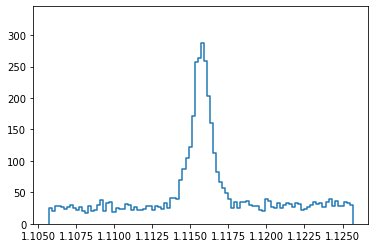

In [23]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 1.115683 - 0.01, 1.115683 + 0.01)).fill(
    ak.flatten(mass(pairs, 0.139570, 0.938272))
))

$K_S \to \pi\pi$ requires unique combinations of pions in each event with themselves.

<img src="../docs-images/diagrams/cartoon-combinations.png" width="300">

In [24]:
pairs = ak.combinations(events.pions, 2, with_name="pair")
pairs

<Array [[({id: 79, pdg: 211, ... )]] type='10000 * var * pair[particle["id": uin...'>

In [25]:
mass(pairs, 0.139570, 0.139570)

<Array [[1.35, 0.661, 0.374, ... 0.356, 0.529]] type='10000 * var * float64'>

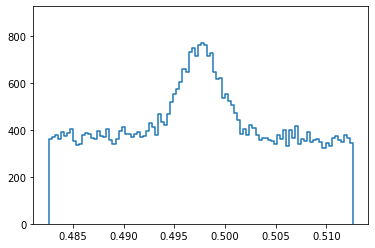

In [26]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.497611 - 0.015, 0.497611 + 0.015)).fill(
    ak.flatten(mass(pairs, 0.139570, 0.139570))
))

## 5. Masking, rather than cutting

One of the problems with using NumPy slicing to cut events is that it changes the shape of arrays; they don't line up.

In [27]:
sample = ak.Array(np.arange(10))
sample

<Array [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] type='10 * int64'>

In [28]:
cut = (sample % 2 == 0)
cut

<Array [True, False, True, ... True, False] type='10 * bool'>

In [29]:
sample[cut]

<Array [0, 2, 4, 6, 8] type='5 * int64'>

One of the data types that can be expressed with Awkward Arrays allows for missing data (arrays containing `None`).

`ak.mask` or `array.mask[...]` can make these arrays.

In [30]:
sample.mask[cut]

<Array [0, None, 2, None, ... 6, None, 8, None] type='10 * ?int64'>

This still has 10 entries, so we can use it in formulae with other arrays with 10 entries.

In [31]:
sample.mask[cut] - sample

<Array [0, None, 0, None, ... 0, None, 0, None] type='10 * ?int64'>

Physics example: apply some quality cuts to $K_S \to \pi\pi$.

In [32]:
pairs = ak.combinations(events.pions, 2, with_name="pair")
pairs

<Array [[({id: 79, pdg: 211, ... )]] type='10000 * var * pair[particle["id": uin...'>

In [33]:
opposite_sign = (pairs.slot0.charge != pairs.slot1.charge)
opposite_sign

<Array [[True, False, True, ... True, True]] type='10000 * var * bool'>

In [34]:
def far_enough(vtx, cut):
    return np.sqrt(vtx.x**2 + vtx.y**2 + vtx.z**2) > cut

left, right = ak.unzip(pairs)
displaced_vertex = far_enough(left.vtx, 0.10) & far_enough(right.vtx, 0.10)
displaced_vertex

<Array [[False, False, False, ... False, True]] type='10000 * var * bool'>

The cuts can be added sequentially.

In [35]:
good_kaons = pairs.mask[opposite_sign]
good_kaons

<Array [[({id: 79, pdg: 211, ... )]] type='10000 * var * ?pair[particle["id": ui...'>

In [36]:
better_kaons = good_kaons.mask[displaced_vertex]
better_kaons

<Array [[None, None, None, None, ... )]] type='10000 * var * ?pair[particle["id"...'>

Flattening at the default `axis=1` concatenates the first level of nested lists (and would get rid of any missing _lists_).

In [37]:
ak.flatten(better_kaons)

<Array [None, None, None, None, None, ... )] type='885743 * ?pair[particle["id":...'>

Flattening at `axis=0` gets rid of missing values at the top level.

In [38]:
ak.flatten(ak.flatten(better_kaons), axis=0)

<Array [({id: 126, pdg: -211, ... )] type='49494 * pair[particle["id": uint64, "...'>

Flattening with `axis=None` eliminates _all_ structure, leaving you with only numbers.

In [40]:
ak.flatten(better_kaons, axis=None)

<Array [126, 126, 126, ... -25, -25, -0.365] type='4157496 * float64'>

We don't want to do that to record structures because we lose the difference between PDG ids and px-py-pzs.

But we could easily want to do that with a numerical array, like masses.

In [41]:
mass(better_kaons, 0.139570, 0.139570)

<Array [[None, None, None, ... None, 0.529]] type='10000 * var * ?float64'>

In [42]:
ak.flatten(mass(better_kaons, 0.139570, 0.139570), axis=None)

<Array [0.336, 0.341, 0.567, ... 0.499, 0.529] type='49494 * float64'>

That's pretty much what you always want to do before plotting.

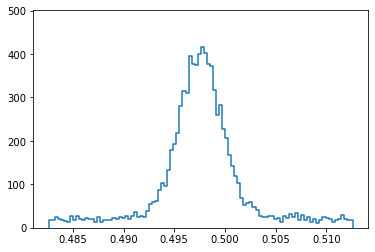

In [43]:
hep.histplot(bh.Histogram(bh.axis.Regular(100, 0.497611 - 0.015, 0.497611 + 0.015)).fill(
    ak.flatten(mass(better_kaons, 0.139570, 0.139570), axis=None)
))

## 6. Easier to override with physics behaviors

## 7. ArrayBuilder

## 8. Everything can be used in Numba

## 9. Everything can be used in Pandas

## 10. NumPy conformance and the "axis" parameter

## 11. Producing and consuming arrays in pure C++

## 12. Documentation!

## 13. Bleeding edge: PartitionedArray and VirtualArray